# Artificial Neural Networks and Deep Learning

---
## Homework 1: Blood cells classification
## Team: The Backpropagators
Arianna Procaccio, Francesco Buccoliero, Kai-Xi Matteo Chen, Luca Capoferri

ariii, frbuccoliero, kaiximatteoc, luke01

246843, 245498, 245523, 259617


## ⚙️ Import Libraries

In [17]:
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import json
import numpy as np
import random
import seaborn as sns
import keras_cv
import tensorflow as tf

In [18]:
seed = 666
np.random.seed(seed)
tf.random.set_seed(seed)

In [19]:
# Define if we wanna assign different class weights (for class imbalance) during model fitting
USE_CLASS_WEIGHTS = False

## ⏳ Load and inspect the data

In [20]:
# Define img shape. Input image is 96x96 hence based on the specified value it will be enlarged or CENTER cropped
IMG_SIZE = 96

if IMG_SIZE < 96:
	print('Image will center cropped!')
elif IMG_SIZE > 96:
	print('Image will be enlarged!')

In [21]:
DATASET = "/kaggle/input/training-data/training_set.npz"
OUTLIERS = "/kaggle/input/blacklist/blacklist.json"

In [22]:
# TODO: maybe adjust
train_ratio = 0.85
validation_ratio = 0.10
test_ratio = 0.05

assert train_ratio + validation_ratio + test_ratio == 1


In [23]:
# Labels
labels = {
	0: "Basophil",
	1: "Eosinophil",
	2: "Erythroblast",
	3: "Immature granulocytes",
	4: "Lymphocyte",
	5: "Monocyte",
	6: "Neutrophil",
	7: "Platelet"
}

In [24]:
data = np.load(DATASET)
X = data['images']
y = data['labels']

X = (X).astype('float32')

print('Before data points filter shape:', X.shape, y.shape)

with open(OUTLIERS, 'r') as file:
	blacklist = json.load(file)
blacklist = sorted(blacklist['blacklist'])
X = np.delete(X, blacklist, axis=0)
y = np.delete(y, blacklist, axis=0)

print('After data points filter shape:', X.shape, y.shape)

# Percentages taken from:  https://arxiv.org/pdf/2110.09508
train_size = int(X.shape[0] * train_ratio)
val_size = int(X.shape[0] * validation_ratio)
test_size = X.shape[0] - train_size - val_size

if not USE_CLASS_WEIGHTS:
	# Convert to one hot encoding
	y = tfk.utils.to_categorical(y)

	if test_size >= len(labels):
		X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)
		X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=val_size, stratify=y_train)
		print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
	else:
		X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=val_size, stratify=y)
		print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
else:
	if test_size >= len(labels):
		X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)
		X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=val_size, stratify=y_train)
	else:
		X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=val_size, stratify=y)
		print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
	# Copy for later
	y_train_cat = y_train
	# Convert to one hot encoding
	y_train = tfk.utils.to_categorical(y_train)
	y_val = tfk.utils.to_categorical(y_val)
	if test_size >= len(labels):
		y_test = tfk.utils.to_categorical(y_test)
		print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
	else:
		print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

Before data points filter shape: (13759, 96, 96, 3) (13759, 1)
After data points filter shape: (11959, 96, 96, 3) (11959, 1)
(10165, 96, 96, 3) (1195, 96, 96, 3) (599, 96, 96, 3) (10165, 8) (1195, 8) (599, 8)


/tmp/ipykernel_84/2406154218.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return labels[int(index)]


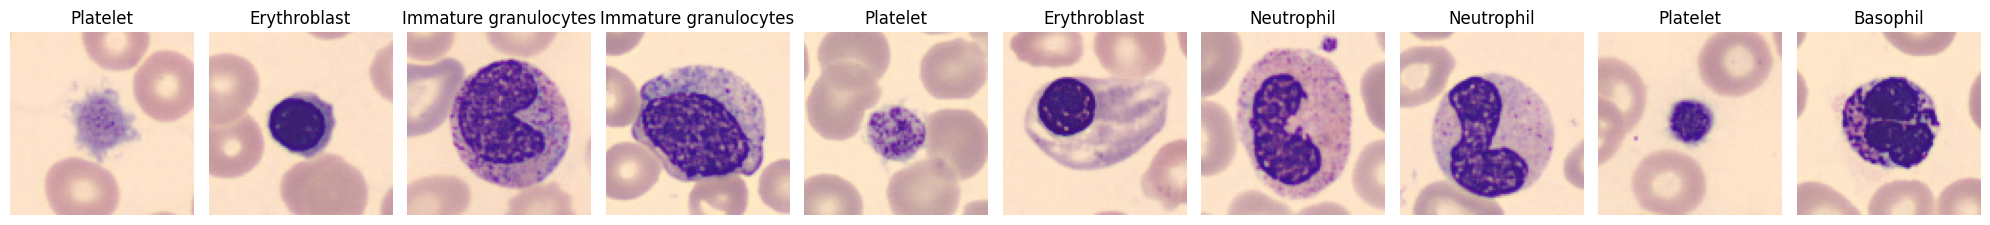

In [25]:
# Inspect data
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

def get_label(y):
    index = np.where(y == 1)[0]
    return labels[int(index)]

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_val[idx] / 255), vmin=0., vmax=1.)
    ax.set_title(get_label(y_val[idx]))
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## 🌊 Generate class weights

In [26]:
if USE_CLASS_WEIGHTS:
    # Flat the train labels
    y_train_cat_flat = np.ravel(y_train_cat)

    # Make weights proportional to class imbalance

    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(data['labels']), 
        y=y_train_cat_flat
    )

    class_weight_dict = dict(enumerate(class_weights))
    from pprint import pprint
    print('Class weights:')
    pprint(class_weight_dict)

## 🛠️ Train and Save the Model

In [27]:
# Define training setup
epochs = 400
batch_size = 64

In [28]:
# Define optimizer setup
lr = 1e-3
fine_tuning_lr = 1e-4
# One of:
# SGD
# Adam
# AdamW
# Lion
# Ranger
opt_name = "AdamW"
fine_tuning_opt_name = "AdamW"

opt_exp_decay_rate: float | None = None
# Decay at how many epochs
opt_decay_epoch_delta = 7

In [29]:

# Define dense params
dropouts_layers = [0.4]
# Note, the base model outputs a size which is different based on the model being used, hence make attention on the first dense size
dense_layers = [8]

# Example for more layers:
#dropouts_layers = [0.5, 0.3, 0.4]
#dense_layers = [256, 64, 8]

In [30]:
# Define fitting callbacks. Comment out from dict the unwanted ones
model_fit_callbacks = {
	#'ReduceLROnPlateau': tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
	'EarlyStopping': tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1) 
}

In [31]:
# just to free or not the memory
FREE_MODEL = False

In [32]:
# Base model name being used. One of:
# vgg19
# vgg16
# efficientnetv2-b0
# efficientnetv2-b3
# efficientnetv2-s
# efficientnetv2-m
# efficientnetv2-l
# They all use global average pooling
base_model_name = 'efficientnetv2-l'

In [33]:
# Define if to load a trained classier based on the same base model
LOAD_TRAINED_CLASSIFIER = False
trained_classifier_model_file = ""

In [34]:
# Layers to fine tune. Use `all` to enable all layers.
ACTIVATION_POLICY = 'prefix' #or 'same'
based_model_layer_blocks_to_activate = set([
	'block1',
	'block2',
	'block3',
	'block4',
	'block5',
	'block6',
	'block7',
])

In [35]:
# This will download every weight. If you have issues (e.g. on Kaggle) please delete the unwanted dict entries
base_model_dict = {
  'efficientnetv2-l': tfk.applications.EfficientNetV2L(
    include_preprocessing=True,
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    input_tensor=None,
    pooling='avg',
    weights="/kaggle/input/efficientnetv2l/keras/default/1/efficientnetv2-l_notop.h5",
  )
}

def get_base_model():
  if LOAD_TRAINED_CLASSIFIER:
    return None
  # Initialise imageNet model with pretrained weights, for transfer learning
  assert(base_model_name in base_model_dict)
  m = base_model_dict[base_model_name]

  # Freeze
  m.trainable = False
  return m

In [39]:
# General augmentations with Keras layers
def build_augmentation(name = 'preprocessing'):
	augmentation = tf.keras.Sequential([
		tfkl.RandomRotation(0.167),                              # Rotate images randomly by ±60% of a full rotation
		tfkl.RandomTranslation(0.1, 0.1),                        # Randomly translate images by ±10% in x and y
	], name=name)
	return augmentation

In [ ]:
# This augmentation pipeline will double the inputs (X) and apply the cutmix+mixup+randarg on 1/3 of them, augmix on 1/3 of them (the returned dataset will have both augmented and not augmented data shuffled).
def get_dataset_augmix_onethird_cutmixmixuprandarg_onethird_augmix_augmented(X, y, batch):
  cutmix = keras_cv.layers.CutMix(alpha=0.5, seed=seed)
  mix_up = keras_cv.layers.MixUp(alpha=0.5, seed=seed)
  augmix = keras_cv.layers.AugMix([0, 255], severity=0.5)
  rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=4, magnitude=0.75 # Default settings
  )

  # Apply augmentations only to X
  def augment_augmix(features, labels):
    features = augmix(features)  # Apply keras_cv transformations to features
    return features, labels  # Return features and labels unchanged


  assert(isinstance(X, np.ndarray))
  assert(isinstance(y, np.ndarray))

  X_t = tf.convert_to_tensor(X, dtype='float32')
  y_t = tf.convert_to_tensor(y, dtype='float32')
  cutmix_dataset = tf.data.Dataset.from_tensor_slices((X_t, y_t))

  # Batch the dataset to use cutmix, mixup and randaug. The batch size is the same as the input size to create one batch
  batched_dataset = cutmix_dataset.batch(X.shape[0])
  #batched_dataset = batched_dataset.map(augment_rand_augment, num_parallel_calls=tf.data.AUTOTUNE)
  # Access each batch and apply CutMix + Mixup
  for batch_features, batch_labels in batched_dataset:
    randarg_applied = rand_augment(batch_features)
    cutmix_applied = cutmix({"images": randarg_applied, "labels": batch_labels})
    mix_up_applied = mix_up(cutmix_applied)
    cutmix_mixup_dataset = tf.data.Dataset.from_tensor_slices((mix_up_applied['images'], mix_up_applied['labels']))
    break

  # Apply augmix
  augmix_dataset = tf.data.Dataset.from_tensor_slices((X_t, y_t))
  augmix_dataset = augmix_dataset.map(augment_augmix, num_parallel_calls=tf.data.AUTOTUNE)

  # Concat augmented with original
  dataset = cutmix_mixup_dataset.concatenate(tf.data.Dataset.from_tensor_slices((X_t, y_t)))
  dataset = dataset.concatenate(augmix_dataset)

  # Shuffle, batch, and optionally preprocess
  dataset = (dataset
             .shuffle(buffer_size=X.shape[0] * 3)   # Shuffle the entire dataset
             .batch(batch)                  # Create batches
             .prefetch(tf.data.AUTOTUNE))  
  return dataset

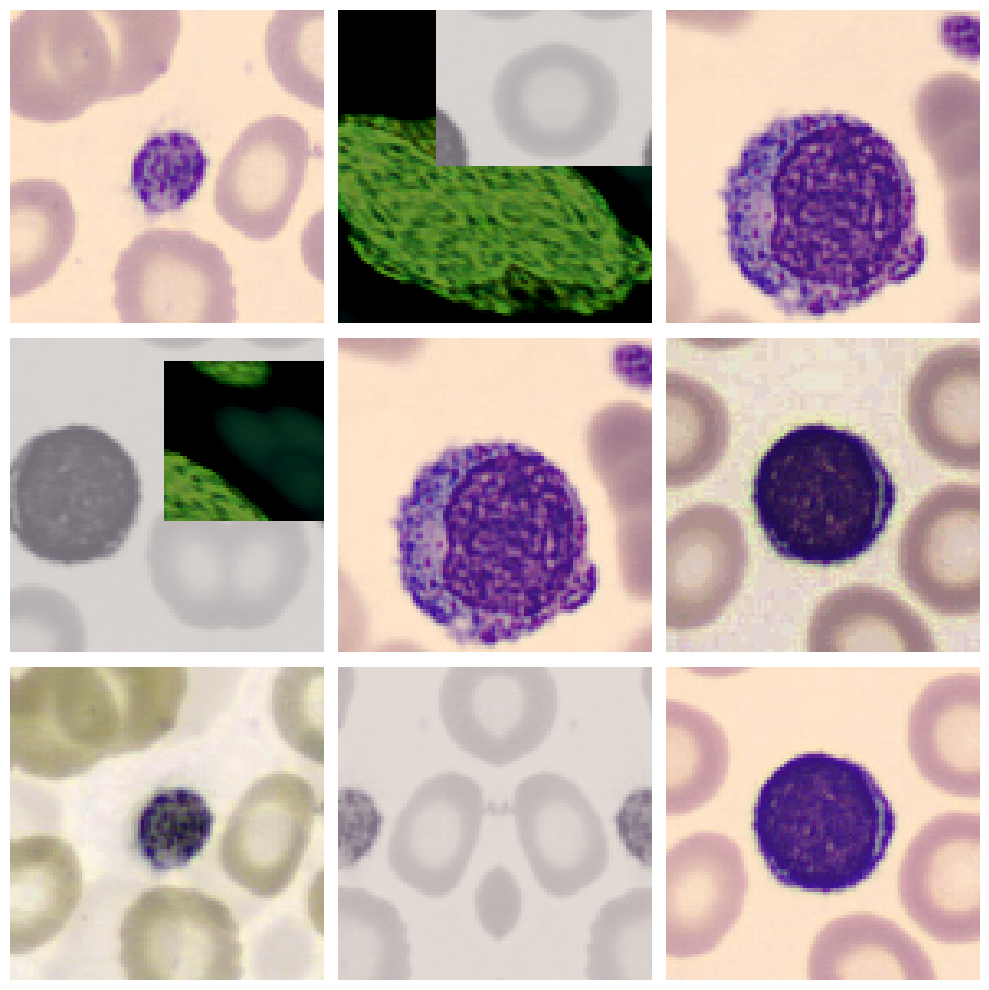

In [49]:
# Test the (cutmix+mixup) + augmix augmentation
N = 3

random_indices = random.sample(range(len(X_train)), N)
test_augmix = get_dataset_augmix_onethird_cutmixmixuprandarg_onethird_augmix_augmented(X_train[random_indices], y_train[random_indices], N*3)

# Take one batch from the dataset
for batch in test_augmix.take(1):
  X_batch, y_batch = batch  # Features and labels

  # Inspect data
  fig, axes = plt.subplots(N, 3, figsize=(10,10))
  # Iterate through the selected number of images
  for i in range(N*3):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.imshow(np.squeeze(X_batch[i].numpy() / 255), vmin=0., vmax=1.)
    ax.axis('off')

  # Adjust layout and display the images
  plt.tight_layout()
  plt.show()

  break

In [50]:
# By default we build a new model with the given base model
# If the flag LOAD_TRAINED_CLASSIFIER is True, we load the model and load the base_model from the loaded model, hence any base_model being passed is ignored
def build_model(base_model = None, restore_base = True, out_shape = y_train.shape[-1], trained_classifier_model_name = 'vgg19'):
	assert(len(dropouts_layers) == len(dense_layers))
	assert(dense_layers[-1] == len(labels))

	if LOAD_TRAINED_CLASSIFIER:
		assert(trained_classifier_model_file != '')
		m = tf.keras.models.load_model(trained_classifier_model_file)

		# Extract the base model
		if restore_base:
			base_model = m.get_layer(trained_classifier_model_name)
			for l in base_model.layers:
				l.trainable = False
			return m

	if restore_base and base_model is not None:
		for l in base_model.layers:
			l.trainable = False

	inputs = tfk.Input(shape=X_train[0].shape, name='input_layer')
	# Define augmentation layers
	augmentation = build_augmentation()
	# Define network
	x = augmentation(inputs)
	if base_model is not None:
		x = base_model(x)
	for i, (drop, dense) in enumerate(zip(dropouts_layers, dense_layers)):
		x = tfkl.Dropout(drop, name=f'dropout{i}')(x)
		# Skip last dense as it's the output
		if i == len(dropouts_layers)-1:
			break
		x = tfkl.Dense(dense, activation='relu', name=f'dense{i}')(x)
	outputs = tfkl.Dense(dense_layers[-1], activation='softmax', name=f'dense{len(dense_layers)-1}')(x)

	# Define the complete model linking input and output
	m = tfk.Model(inputs=inputs, outputs=outputs, name='model')
	return m

In [51]:
def get_callbacks():
	return [i for i in model_fit_callbacks.values()]

In [52]:
def fit_model(model, data_loader = None):
	if data_loader is None:
		if USE_CLASS_WEIGHTS:
			print('Fitting with class weights!')
			fit_history = model.fit(
	      x=X_train,
	      y=y_train,
	      batch_size=batch_size,
	      epochs=epochs,
	      validation_data=(X_val, y_val),
	      class_weight = class_weight_dict,
	      callbacks=get_callbacks()
	    ).history
		else:
			fit_history = model.fit(
	      x=X_train,
	      y=y_train,
	      batch_size=batch_size,
	      epochs=epochs,
	      validation_data=(X_val, y_val),
	      callbacks=get_callbacks()
	    ).history
		return fit_history
	else:
		if USE_CLASS_WEIGHTS:
			print('Fitting with class weights!')
			fit_history = model.fit(
        data_loader,
	      batch_size=batch_size,
	      epochs=epochs,
	      validation_data=(X_val, y_val),
	      class_weight = class_weight_dict,
	      callbacks=get_callbacks()
	    ).history
		else:
			fit_history = model.fit(
        data_loader,
	      batch_size=batch_size,
	      epochs=epochs,
	      validation_data=(X_val, y_val),
	      callbacks=get_callbacks()
	    ).history
		return fit_history

In [53]:
def enable_feature_extractor_layers(extractor, layers):
  extractor.trainable = True
  for i, layer in enumerate(extractor.layers):
    layer.trainable = False
	# Set the based_model_layer_blocks_to_activate layers as trainable
  if 'all' in layers:
    for i, layer in enumerate(extractor.layers):
      layer.trainable = True
  else:
    if ACTIVATION_POLICY == 'same':
      for i, layer in enumerate(extractor.layers):
        if layer.name in layers:
          layer.trainable = True
    elif ACTIVATION_POLICY == 'prefix':
      for i, layer in enumerate(extractor.layers):
        block = layer.name[:6]
        if block in layers:
          layer.trainable = True

	# Print layer indices, names, and trainability status
  print('\n\nBase model training configuration:')
  for i, layer in enumerate(extractor.layers):
	  print(i, layer.name, layer.trainable)

In [54]:
# Taken from https://github.com/SeanSdahl/RangerOptimizerTensorflow/blob/master/module.py
def build_ranger(lr=1e-3, weight_decay=0.0):
  try:
    import tensorflow_addons as tfa
  except:
    raise Exception("You have to install tensorflow_addons package for Ranger. Please note that this package is available up to tensorflow==2.14")
  def ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=lr,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=weight_decay,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim
  return ranger()

In [55]:
def get_optimizer(is_fine_tuning = False, use_decay_fine_tuning = False, **kwargs):
	decay = opt_exp_decay_rate
	if is_fine_tuning and not use_decay_fine_tuning:
		decay = None

	opt = opt_name if not is_fine_tuning else fine_tuning_opt_name

	if opt == "SGD":
		optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9 if 'momentum' not in kwargs else kwargs['momentum'])
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate=fine_tuning_lr if is_fine_tuning else lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer with exp decay {decay} (momentum = {optimizer.momentum})\n\n')
			return optimizer
		else:
			optimizer.learning_rate = fine_tuning_lr if is_fine_tuning else lr
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer (momentum = {optimizer.momentum})\n\n')
			return optimizer

	elif opt == "Adam":
		if 'weight_decay' in kwargs:
			optimizer = tf.keras.optimizers.Adam(weight_decay=kwargs['weight_decay'])
		else:
			optimizer = tf.keras.optimizers.Adam()
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate=fine_tuning_lr if is_fine_tuning else lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}\n\n')
			return optimizer
		else:
			optimizer.learning_rate = fine_tuning_lr if is_fine_tuning else lr
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer (weight decay = {optimizer.weight_decay})\n\n')
			return optimizer

	elif opt == "AdamW":
		if 'weight_decay' in kwargs:
			optimizer = tf.keras.optimizers.AdamW(weight_decay=kwargs['weight_decay'])
		else:
			optimizer = tf.keras.optimizers.AdamW()
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate=fine_tuning_lr if is_fine_tuning else lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}\n\n')
			return optimizer
		else:
			optimizer.learning_rate = fine_tuning_lr if is_fine_tuning else lr
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer (weight decay = {optimizer.weight_decay})\n\n')
			return optimizer

	elif opt == "Lion":
		if 'weight_decay' in kwargs:
			optimizer = tf.keras.optimizers.Lion(weight_decay=kwargs['weight_decay'])
		else:
			optimizer = tf.keras.optimizers.Lion()
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate=fine_tuning_lr if is_fine_tuning else lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}\n\n')
			return optimizer
		else:
			optimizer.learning_rate = fine_tuning_lr if is_fine_tuning else lr
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer (weight decay = {optimizer.weight_decay})\n\n')
			return optimizer
	elif opt == "Ranger":
		optimizer = build_ranger(lr=lr if not is_fine_tuning else fine_tuning_lr, weight_decay=0.0 if 'weight_decay' not in kwargs else kwargs['weight_decay'])
		if decay is not None:
			raise RuntimeError("Not supported")
		else:
			optimizer.learning_rate = fine_tuning_lr if is_fine_tuning else lr
			print(f'\n\n{"Finetuning: " if is_fine_tuning else "NotFinetuning: "}using {opt} optimizer\n\n')
			return optimizer

In [56]:
def display_model(model):
	# Display a summary of the model architecture
	model.summary(expand_nested=True)

	# Display model architecture with layer shapes and trainable parameters
	tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:

'''
Classifier training
'''
model = build_model(base_model=get_base_model())
base_model = model.get_layer(base_model_name)

if not LOAD_TRAINED_CLASSIFIER:
  model.compile(loss=keras_cv.losses.FocalLoss(label_smoothing=0.1), optimizer=get_optimizer(is_fine_tuning=False), metrics=['accuracy'])
  #display_model(model)
  
  # Fit the initial model
  print('\n\nFitting classifier\n\n')
  # Pass a data loader if we want to pass a loader object which applied some aug (e.g. cutmix)
  class_fit_history = fit_model(model, data_loader=get_dataset_augmix_onethird_cutmixmixuprandarg_onethird_augmix_augmented(X_train, y_train, batch_size))
  
  intermediate_val_acc = round(max(class_fit_history['val_accuracy']) * 100, 2)
  # Save intermediate model
  model_filename = f'{base_model_name}-intermediateDONOTUSE-finetuned{len(based_model_layer_blocks_to_activate) if "all" not in based_model_layer_blocks_to_activate else "all"}blocks-{str(intermediate_val_acc)}-{datetime.now().strftime("%y%m%d_%H%M")}.keras'
  model.save(model_filename)

'''
Fine tuning
'''
# Enable fine tuning
enable_feature_extractor_layers(base_model, based_model_layer_blocks_to_activate)

model.compile(loss=keras_cv.losses.FocalLoss(label_smoothing=0.1), optimizer=get_optimizer(is_fine_tuning=True), metrics=['accuracy'])
#display_model(model)

# Fit the initial finetuned model
print('\n\nFine tuning\n\n')
# Pass a data loader if we want to pass a loader object which applied some aug (e.g. cutmix)
fine_tuning_fit_history = fit_model(model, data_loader=get_dataset_augmix_onethird_cutmixmixuprandarg_onethird_augmix_augmented(X_train, y_train, batch_size))

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(fine_tuning_fit_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{base_model_name}-finetuned{len(based_model_layer_blocks_to_activate) if "all" not in based_model_layer_blocks_to_activate else "all"}blocks-{str(final_val_accuracy)}-{datetime.now().strftime("%y%m%d_%H%M")}.keras'
model.save(model_filename)

# Free memory by deleting the model instance
if FREE_MODEL:
  del model



NotFinetuning: using AdamW optimizer (weight decay = 0.004)




Fitting classifier


Epoch 1/400


2024-11-21 21:09:55.815534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/model_1/efficientnetv2-l_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


477/477 ━━━━━━━━━━━━━━━━━━━━ 170s 152ms/step - accuracy: 0.3845 - loss: 0.3464 - val_accuracy: 0.8385 - val_loss: 0.1806
Epoch 2/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 114s 126ms/step - accuracy: 0.5660 - loss: 0.2768 - val_accuracy: 0.8669 - val_loss: 0.1628
Epoch 3/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 114s 125ms/step - accuracy: 0.5765 - loss: 0.2743 - val_accuracy: 0.8753 - val_loss: 0.1502
Epoch 4/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 113s 125ms/step - accuracy: 0.5873 - loss: 0.2687 - val_accuracy: 0.8544 - val_loss: 0.1545
Epoch 5/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 114s 126ms/step - accuracy: 0.5866 - loss: 0.2685 - val_accuracy: 0.8728 - val_loss: 0.1489
Epoch 6/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 112s 124ms/step - accuracy: 0.5876 - loss: 0.2689 - val_accuracy: 0.8711 - val_loss: 0.1512
Epoch 7/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 112s 124ms/step - accuracy: 0.5961 - loss: 0.2673 - val_accuracy: 0.8611 - val_loss: 0.1493
Epoch 8/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 113s 124ms/step - accuracy: 0.5937 - los

2024-11-21 22:50:19.213987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/model_1/efficientnetv2-l_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


477/477 ━━━━━━━━━━━━━━━━━━━━ 494s 574ms/step - accuracy: 0.6467 - loss: 0.2217 - val_accuracy: 0.9858 - val_loss: 0.0261
Epoch 2/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 318s 551ms/step - accuracy: 0.7904 - loss: 0.1407 - val_accuracy: 0.9824 - val_loss: 0.0226
Epoch 3/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 316s 551ms/step - accuracy: 0.8209 - loss: 0.1230 - val_accuracy: 0.9757 - val_loss: 0.0341
Epoch 4/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 316s 551ms/step - accuracy: 0.8426 - loss: 0.1115 - val_accuracy: 0.9866 - val_loss: 0.0190
Epoch 5/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 317s 550ms/step - accuracy: 0.8516 - loss: 0.1077 - val_accuracy: 0.9841 - val_loss: 0.0229
Epoch 6/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 318s 555ms/step - accuracy: 0.8615 - loss: 0.1013 - val_accuracy: 0.9874 - val_loss: 0.0226
Epoch 7/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 316s 550ms/step - accuracy: 0.8780 - loss: 0.0935 - val_accuracy: 0.9849 - val_loss: 0.0291
Epoch 8/400
477/477 ━━━━━━━━━━━━━━━━━━━━ 317s 550ms/step - accuracy: 0.8854 - los

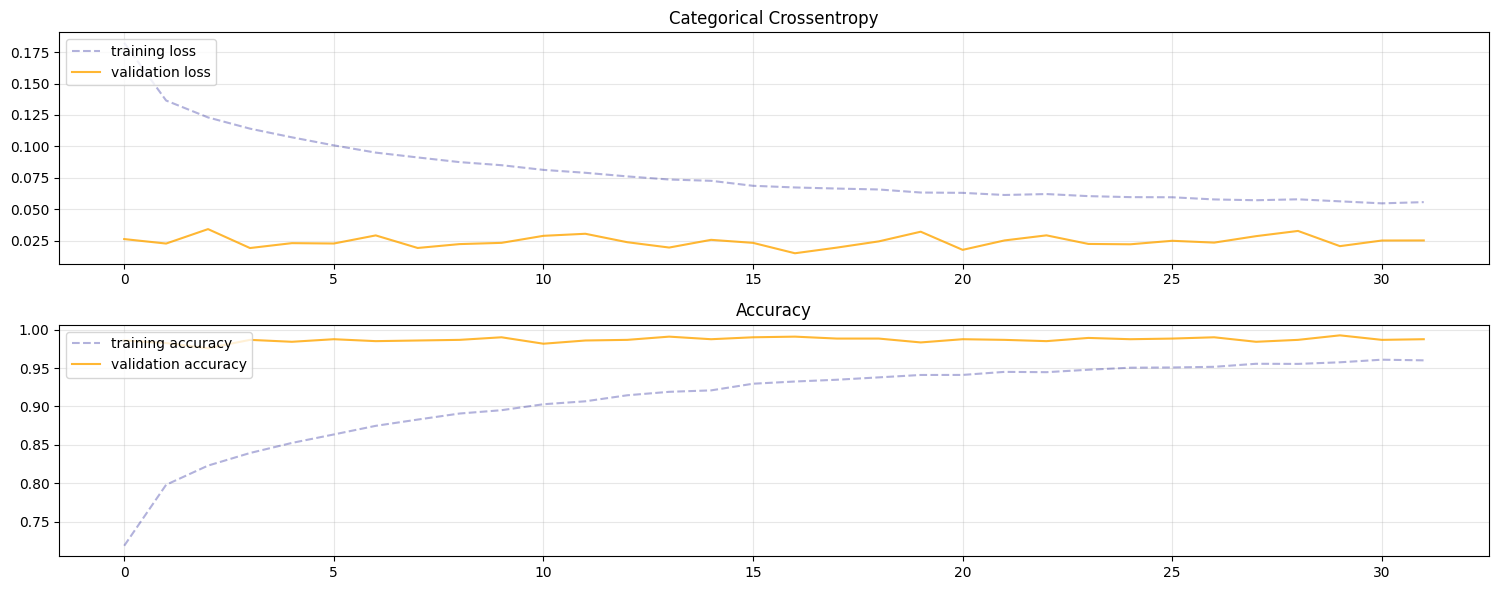

In [58]:
def plot_trainig(fit):
	# Create figure and subplots for loss and accuracy
	fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

	# Plot loss for both re-trained and transfer learning models
	ax1.plot(fit['loss'], alpha=0.3, color='#00008b', label='training loss', linestyle='--')
	ax1.plot(fit['val_loss'], label='validation loss', alpha=0.8, color='#ffa500')
	ax1.set_title('Categorical Crossentropy')
	ax1.legend(loc='upper left')
	ax1.grid(alpha=0.3)

	# Plot accuracy for both re-trained and transfer learning models
	ax2.plot(fit['accuracy'], alpha=0.3, color='#00008b', label='training accuracy', linestyle='--')
	ax2.plot(fit['val_accuracy'], label='validation accuracy', alpha=0.8, color='#ffa500')
	ax2.set_title('Accuracy')
	ax2.legend(loc='upper left')
	ax2.grid(alpha=0.3)

	# Adjust layout to prevent label overlap and display the plots
	plt.tight_layout()
	plt.show()

#plot_trainig(class_fit_history)
plot_trainig(fine_tuning_fit_history)

## ✍🏿 Make evaluation

Predictions Shape: (599, 8)
Accuracy score over the test set: 99.17%
Precision score over the test set: 99.18%
Recall score over the test set: 99.17%
F1 score over the test set: 99.17%


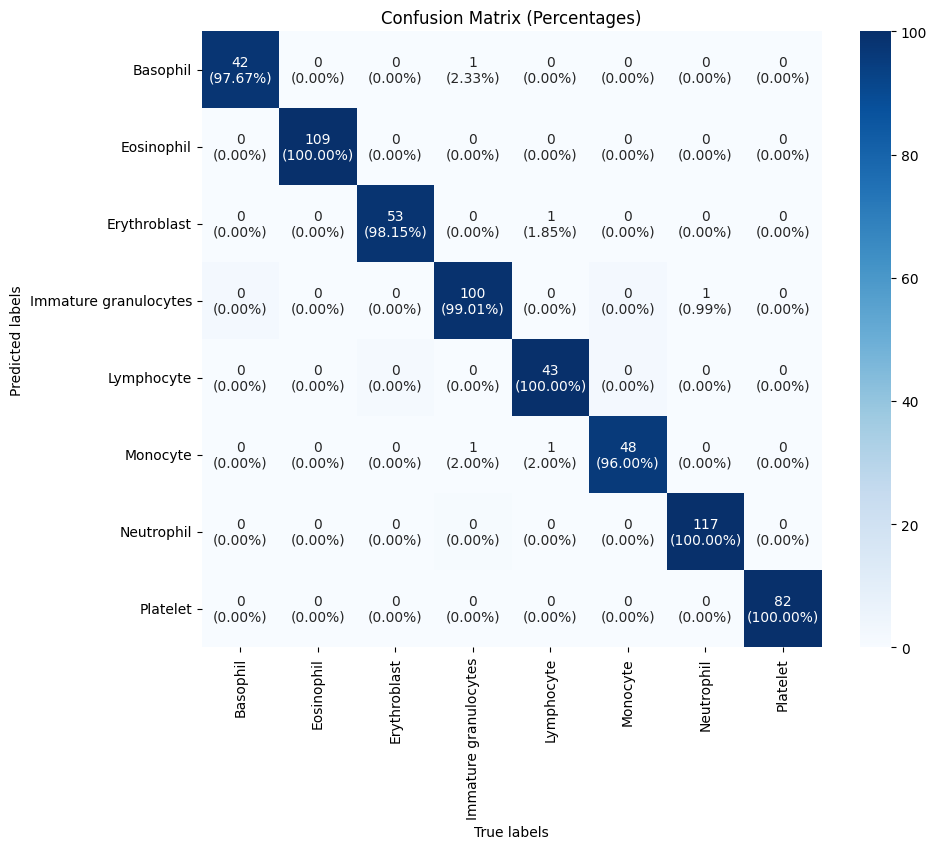

In [60]:
##loss, acc = model.evaluate(X_test, y_test, verbose=2)
##print('Model, accuracy: {:5.2f}%'.format(100 * acc))

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy as percentage
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(100 * accuracy, 2)}%')

# Calculate and display test set precision as percentage
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(100 * precision, 2)}%')

# Calculate and display test set recall as percentage
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(100 * recall, 2)}%')

# Calculate and display test set F1 score as percentage
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(100 * f1, 2)}%')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Calculate the percentages for each element in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}\n({percent:.2f}%)" for num, percent in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape)

# Plot the confusion matrix with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix (Percentages)')
plt.show()
